In [28]:
import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

data = pykitti.raw(kitty_dir, kitty_date, kitty_drive)

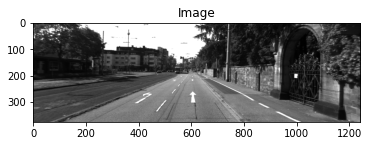

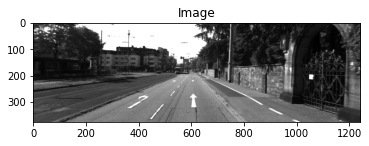

In [29]:
img1 = np.array(data.get_cam0(50))
img2 = np.array(data.get_cam0(51))
img3 = np.array(data.get_cam0(52))
K = data.calib.K_cam0

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

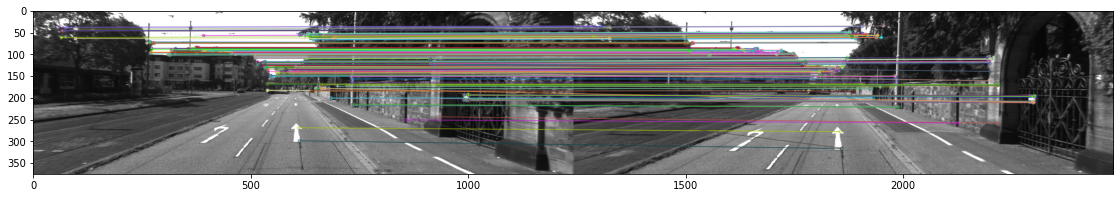

In [30]:
# From: https://stackoverflow.com/a/33670318
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
plt.figure(figsize=(30, 3))
plt.imshow(match_img)
plt.show()

In [31]:
# From book
imgpts1 = []
imgpts2 = []
for match in matches:
	imgpts1.append(kp1[match.queryIdx].pt)
	imgpts2.append(kp2[match.trainIdx].pt)

points1 = np.array(imgpts1)
points2 = np.array(imgpts2)

F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 1000)
E = K.T @ F @ K
print("E:", E)

print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")
status_mask = status_mask[:, 0] == 1
points1 = points1[status_mask]
points2 = points2[status_mask]



E: [[-1.04074273e+00  2.42289023e+02 -3.83391144e+01]
 [-2.14197542e+02 -3.33860666e+01 -3.47585014e+15]
 [ 4.19867028e+01  3.47585014e+15 -1.25000000e-01]]
Keeping 119/348 points that match the fundamental matrix


In [32]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:,np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

P, P1

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[-1.00000000e+00,  1.04940899e-15, -8.08190219e-15,
         -1.00000000e+00],
        [-1.04940899e-15, -1.00000000e+00,  4.80674876e-15,
          1.10301402e-14],
        [ 8.08190219e-15, -4.79869435e-15, -1.00000000e+00,
          6.97064064e-14]]))

## Triangulation

In [33]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P and P1 do)
	u: np.array, # point in image 1: (x, y, 1)
	P: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[ u[0]*P[2,0]-P[0,0],    u[0]*P[2,1]-P[0,1],    u[0]*P[2,2]-P[0,2]],
		[ u[1]*P[2,0]-P[1,0],    u[1]*P[2,1]-P[1,1],    u[1]*P[2,2]-P[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u[0]*P[2, 3]-P[0, 3]),
		-(u[1]*P[2, 3]-P[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [34]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u, P, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		xPt_img = K @ P1 @ X
		xPt_img_normalized = xPt_img[0:1] / xPt_img[2]
		reproj_error.append(np.linalg.norm(xPt_img_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


err, point_cloud = triangulate_points(points1, points2, K, P, P1)
print("Mean reprojection error:", err)
point_cloud


Mean reprojection error: 486.1647500430832


[CloudPoint(point_3d=array([ 2.33997167e+13,  1.02664347e+13, -8.74303072e+13]), point_2d_2=array([416.44802856,  88.12800598])),
 CloudPoint(point_3d=array([ 7.67470779e+12,  2.79801525e+12, -9.02880464e+13]), point_2d_2=array([548.22680664, 150.49363708])),
 CloudPoint(point_3d=array([-47.96232567, -30.35969023, 347.96749457]), point_2d_2=array([512.17926025, 109.90081787])),
 CloudPoint(point_3d=array([ 2.41396777e+13,  9.80042535e+12, -8.75320528e+13]), point_2d_2=array([410.57290649,  92.06786346])),
 CloudPoint(point_3d=array([-32.30498755, -31.03744484, 501.0669977 ]), point_2d_2=array([564.4800415 , 128.16000366])),
 CloudPoint(point_3d=array([ 3.40771505e+13,  8.14086545e+12, -8.28459318e+13]), point_2d_2=array([312.76803589, 101.95201111])),
 CloudPoint(point_3d=array([-24.96172282, -19.35928757, 347.96237349]), point_2d_2=array([559.87207031, 132.7104187 ])),
 CloudPoint(point_3d=array([  4.03815944, -23.35927286, 347.96237349]), point_2d_2=array([620.00646973, 124.41601562]

In [35]:
def point_cloud_to_numpy(point_cloud):
	return np.array([p.point_3d for p in point_cloud])

In [37]:
# Not really from book, because the book's implementation of this is incomprehensible
success, rvec, t, inliers = cv2.solvePnPRansac(point_cloud_to_numpy(point_cloud), points2, K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P1_new = np.hstack((R, t))
P1, P1_new
P1 - P1_new # No change, which makes sense because it's the same data

array([[-2.00000000e+00, -7.72163596e-08, -5.67001846e-07,
         6.96481101e+07],
       [ 7.72164170e-08, -2.00000000e+00, -1.01305708e-07,
         3.67243204e+07],
       [ 5.67001838e-07,  1.01305752e-07, -2.00000000e+00,
        -4.88309350e+08]])

## Try a 3rd Frame

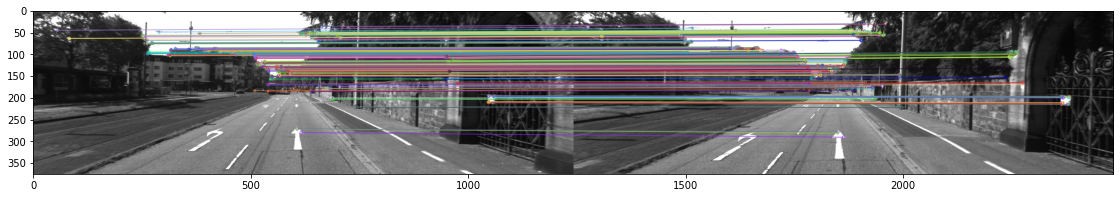

In [23]:
# I made this part up, although it's an amalgamation of code from above which came from other places
orb = cv2.ORB_create()
kp3, des3 = orb.detectAndCompute(img3, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des2, des3)
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img2, kp2, img3, kp3, matches, None, flags=2)
plt.figure(figsize=(30, 3))
plt.imshow(match_img)
plt.show()

imgpts3_valid = []
for match in matches:
	point2 = kp2[match.queryIdx].pt
	point3 = kp3[match.trainIdx].pt

	

points2_new = np.array(imgpts2)
points3 = np.array(imgpts3)

# F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 10000000)
# E = K.T @ F @ K
# print("E:", E)

# print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")
# points1 = points1[status_mask[:, 0]]
# points2 = points2[status_mask[:, 0]]



In [ ]:
for 

In [13]:
print(point_cloud.shape, len(points3))
success, rvec, t, inliers = cv2.solvePnPRansac(point_cloud, points3, K, None)
assert success, "PnP failed!"

R, _ = cv2.Rodrigues(rvec)

P2 = np.hstack((R, t))

(348, 3) 353


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/solvepnp.cpp:241: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'
